In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## ハード投票分類器
個別の分類器の多数決を全体の予測にする分類器をハード投票分類器とよぶ. データはmake_moonsデータセットを用いる.

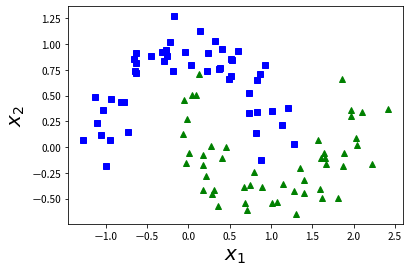

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

plt.figure(facecolor="white")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.xlabel("$x_1$",fontsize=20)
plt.ylabel("$x_2$",fontsize=20)
plt.show()

In [3]:
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from sklearn.ensemble import VotingClassifier # 投票分類器
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# train,test生成
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

log_clf = LogisticRegression() # ロジスティック回帰
rnd_clf = RandomForestClassifier() # ランダムフォレスト
svm_clf = SVC() # SVM

# 投票分類器を定義
voting_clf = VotingClassifier([('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
                              voting = 'hard' # ハード投票分類器に設定
                             )

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train) # 学習
    y_pred = clf.predict(X_test) # 予測
    # 訓練アルゴリズムと正解率を表示
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.84
RandomForestClassifier 0.96
SVC 0.92
VotingClassifier 0.92


## ソフト投票分類器
各投票器が,インスタンスが各クラスに属する確率を推計できるとき,その確率の平均を全体の予測にする投票器をソフト投票分類器とよぶ.

In [7]:
log_clf = LogisticRegression() # ロジスティック回帰
rnd_clf = RandomForestClassifier() # ランダムフォレスト
svm_clf = SVC(probability=True) # ソフト投票分類器のときはprobability=Trueにする

# 投票分類器を定義
voting_clf = VotingClassifier([('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
                              voting = 'soft' # ソフト投票分類器に設定
                             )

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [8]:
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train) # 学習
    y_pred = clf.predict(X_test) # 予測
    # 訓練アルゴリズムと正解率を表示
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.84
RandomForestClassifier 0.96
SVC 0.92
VotingClassifier 0.88


## バギング
バギングはすべての分類器で同じ訓練アルゴリズムを用いて,訓練セットから無作為重複ありでサンプリングを行う手法である.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier # 決定木

# train,test生成
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

# n_estimators : 分類器の数
# max_samples : 無作為抽出する訓練インスタンスの数
# bootstrap : Trueのときバギング,Falseのときぺースティング
# n_jobs : 使用するCPUのコア数
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(),n_estimators=500,
                max_samples=40,bootstrap=True,n_jobs=-1)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
y_pred

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0], dtype=int64)

## ぺースティング
ペースティングは,バギング同様にすべての分類器で同じ訓練アルゴリズムを用いる.ペースティングでは訓練セットから無作為重複なしでサンプリングを行う.

In [13]:
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(),n_estimators=500,
                max_samples=len(X_train),bootstrap=False,n_jobs=-1) # bootstrapの真偽でバギング,ぺースティングを切り替え
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
y_pred

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0], dtype=int64)

## OOB検証
OOB(out of bag)とは,訓練セットとしてサンプリングされなかったインスタンスのことである.このインスタンスを検証に用いることで検証セットの作成や交差検証の手間を省略することができる.

In [15]:
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(),n_estimators=500,
                max_samples=len(X_train),bootstrap=True,n_jobs=-1,oob_score=True) # oob_score=TrueでOOB検証を設定
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.9333333333333333

In [16]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.92

OOB検証でのテストデータに対する正解率は約0.93で,テストデータに対する正解率は0.92であり非常に近い値である.

## ランダムフォレスト
ランダムフォレストは決定木のアンサンブルで一般にバギングメソッドで訓練される. また特徴量の重要度を測定できる訓練アルゴリズムである.

In [4]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators : 分類器の数
# max_leaf_nodes : ノードの最大数
# n_jobs : CPUのコア数
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)
y_pred_rf

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0], dtype=int64)

## ランダムフォレストによる特徴量の重要度測定
ランダムフォレストを用いることで特徴量の重要度を測定することができる.ここではirisデータを用いて特徴量の重要度を測定してみる.

In [5]:
# iris-dataのロード
from sklearn.datasets import load_iris
iris = load_iris()

# ランダムフォレストのインスタンス化と学習
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris["data"],iris["target"])

# 特徴量の重要度の標準出力
# zip() : 引数として与えたリストからそれぞれ一つずつ抽出
for name,score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.09912873926789002
sepal width (cm) 0.024544501785273926
petal length (cm) 0.43022913393158196
petal width (cm) 0.4460976250152542


`petal width`(花弁の幅)が44%,`petal length`(花弁の長さ)が43%で最も重要であり,がく片の長さや幅はそれほど重要な特徴量ではないことがわかる.

## AdaBoost
AdaBoostは逐次的に予測器を訓練するブースティングと呼ばれるアルゴリズムのひとつである. AdaBoostは逐次的に予測器の訓練を行い,前の予測器が過少適合したインスタンスに注意を払う(重みを大きくする)ことで,難しい条件についてよく学習した予測器を作成するという考え方である.  

Documents : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# AdaBoostをインスタンス化
# n_estimators : 学習の繰り返し回数,早期打ち切りあり
# learning_rate : 各学習器が寄与する割合,n_estimatorsとlearning_rateはトレードオフ
# algorithm : ブースティングに用いるアルゴリズム(Documents,sklearnとtensorflowによる実践機械学習P194を参照)
ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),n_estimators=200,
            algorithm="SAMME.R",learning_rate=0.5)
ada_clf.fit(X_train,y_train)
ada_clf.predict(X_test)

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0], dtype=int64)

## 勾配ブースティング
勾配ブースティングも予測器を訓練するときにブースティングを行うアルゴリズムのひとつである. 勾配ブースティグは前の予測器の残差に適合することでより良い学習器を作成するこという考え方である.

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train,y_train)

y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor()
tree_reg2.fit(X_train,y2)

y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor()
tree_reg3.fit(X_train,y3)

y_pred = sum(tree.predict(X_test) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred

array([ 1.        ,  0.82939189,  0.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  0.        ,  1.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        , -0.10810811,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ])